# Project - Structural brain volumes in children with parental psychopathology
### Code for the linear mixed models was written by HH 

### Install and load packages

In [3]:
#install packages 
if (!('lme4'     %in% installed.packages()[,"Package"])) install.packages('lme4')
if (!('EMAtools' %in% installed.packages()[,"Package"])) install.packages('EMAtools')
if (!('naniar'   %in% installed.packages()[,"Package"])) install.packages('naniar')
if (!('jtools'   %in% installed.packages()[,"Package"])) install.packages('jtools')
if (!('ggplot2'  %in% installed.packages()[,"Package"])) install.packages('ggplot2')
if (!('sjPlot'   %in% installed.packages()[,"Package"])) install.packages('sjPlot')
if (!('glmmTMB'  %in% installed.packages()[,"Package"])) install.packages('glmmTMB')
if (!('effects'  %in% installed.packages()[,"Package"])) install.packages('effects')
if (!('robustHD' %in% installed.packages()[,"Package"])) install.packages('robustHD')

# load libraries
if(!"lme4" %in% .packages())     library(lme4)
if(!"EMAtools" %in% .packages()) library(EMAtools)
if(!"naniar" %in% .packages())   library(naniar)
if(!"jtools" %in% .packages())   library(jtools)
if(!"ggplot2" %in% .packages())  library(ggplot2)
if(!"sjPlot" %in% .packages())   library(sjPlot)
if(!"glmmTMB" %in% .packages())  library(glmmTMB)
if(!"effects" %in% .packages())  library(effects)
if(!"robustHD" %in% .packages())  library(robustHD)


### Set working directory and load csv file 

In [ ]:
#set working directory to import PsychRisk3.tsv file that was created with the psychrisk_exploration.ipynb notebook
setwd("/shared/project-psychopathology-risk/outputs/exploration/")
df <- read.table(file = 'PsychRisk_data.tsv', sep = '\t', header = TRUE)
head(df, 5) #inspect dataframe
colnames(df)
str(df)

In [300]:
which( colnames(df)=='smri_vol_scs_aal') #first smri variable in df
which( colnames(df)=='smri_vol_scs_subcorticalgv') #last smri variable in df
which( colnames(df)=='demo_prnt_ed_v2') #column name 

[1] 12

[1] 27

[1] 41

In [301]:
# Specify datatype
names1 <- c(1,4:6, 8:11, 28:39, 42:48) #column numbers categorical variables
df[names1]<- lapply(df[names1],factor)
df$interview_date <- as.Date(df$interview_date, "%m/%d/%Y")
df$interview_age <- as.numeric(df$interview_age)
df$demo_prnt_ed_v2 <- as.numeric(df$demo_prnt_ed_v2)
str(df)

'data.frame':	10589 obs. of  48 variables:
 $ subjectkey                   : Factor w/ 10589 levels "NDAR_INV003RTV85",..: 9 22 25 35 39 43 48 55 68 86 ...
 $ interview_date               : Date, format: "2017-08-19" "2017-08-09" ...
 $ interview_age                : num  121 129 122 122 126 128 128 120 122 127 ...
 $ sex                          : Factor w/ 2 levels "F","M": 2 2 1 2 1 2 1 1 2 1 ...
 $ eventname                    : Factor w/ 1 level "baseline_year_1_arm_1": 1 1 1 1 1 1 1 1 1 1 ...
 $ rel_family_id                : Factor w/ 8834 levels "1","3","4","5",..: 6129 661 8524 6485 6130 7273 2425 6486 8525 6490 ...
 $ acs_raked_propensity_score   : num  616 426 322 428 959 ...
 $ race_ethnicity               : Factor w/ 5 levels "1","2","3","4",..: 5 1 1 1 1 1 1 3 1 1 ...
 $ mri_info_deviceserialnumber  : Factor w/ 30 levels "","HASH03db707f",..: 2 7 4 19 2 10 3 19 4 19 ...
 $ site_id_l                    : Factor w/ 22 levels "site01","site02",..: 11 16 2 6 11 9 14 6 2 6 ...

In [302]:
# replace value 999 to NA 
df <- df %>%
  replace_with_na(replace = list(demo_comb_income_v2 = c(999, 777)))

In [27]:
#standardize smri variables with scale.many function
scale.many <- function(dat, column.nos) {
  nms <- names(dat)
  for(col in column.nos) {
    name <- paste(nms[col],".z", sep = "")
    dat[name] <- scale(dat[,col])
  }
  cat(paste("Scaled ", length(column.nos), " variable(s)\n"))
  dat
}

df <- scale.many(df, c(3, 7, 12:27, 41)) #Add standardized age, acs_raked_propensity_score, smri_vol_scs*, and demo_comb_income_v2 to df with .z extension

Scaled  19  variable(s)


In [303]:
head(df, 5) #inspect dataframe
colnames(df)

,subjectkey,interview_date,interview_age,sex,eventname,rel_family_id,acs_raked_propensity_score,race_ethnicity,mri_info_deviceserialnumber,site_id_l,⋯,famhx_ss_parent_nrv_p,demo_comb_income_v2,demo_prnt_ed_v2,famhx_ss_moth_addiction,famhx_ss_fath_addiction,famhx_ss_momdad_addiction,famhx_ss_parent_addiction_bin,famhx_ss_parent_dprs_bin,famhx_ss_parent_ma_bin,famhx_ss_parent_nrv_bin
,<fct>,<date>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,⋯,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,NDAR_INV00LJVZK2,2017-08-19,121,M,baseline_year_1_arm_1,8315,616.1476,5,HASH03db707f,site11,⋯,0,1,11,0,0,0,0,0,0,0
2,NDAR_INV01NAYMZH,2017-08-09,129,M,baseline_year_1_arm_1,862,425.6335,1,HASH3935c89e,site16,⋯,0,9,15,1,0,1,0,0,0,0
3,NDAR_INV01Z8HAPV,2017-11-19,122,F,baseline_year_1_arm_1,11328,321.6282,1,HASH1314a204,site02,⋯,0,10,19,0,0,0,0,0,0,0
4,NDAR_INV02RCED7D,2017-05-09,122,M,baseline_year_1_arm_1,8783,428.3225,1,HASH96a0c182,site06,⋯,2,9,11,0,0,0,0,0,0,0
5,NDAR_INV030X9ZNH,2018-06-11,126,F,baseline_year_1_arm_1,8316,958.7208,1,HASH03db707f,site11,⋯,0,8,19,0,0,0,0,0,0,0


[1] "subjectkey"                    "interview_date"               
 [3] "interview_age"                 "sex"                          
 [5] "eventname"                     "rel_family_id"                
 [7] "acs_raked_propensity_score"    "race_ethnicity"               
 [9] "mri_info_deviceserialnumber"   "site_id_l"                    
[11] "pds_p_ss_female_category"      "smri_vol_scs_aal"             
[13] "smri_vol_scs_aar"              "smri_vol_scs_amygdalalh"      
[15] "smri_vol_scs_amygdalarh"       "smri_vol_scs_caudatelh"       
[17] "smri_vol_scs_caudaterh"        "smri_vol_scs_hpuslh"          
[19] "smri_vol_scs_hpusrh"           "smri_vol_scs_pallidumlh"      
[21] "smri_vol_scs_pallidumrh"       "smri_vol_scs_putamenlh"       
[23] "smri_vol_scs_putamenrh"        "smri_vol_scs_tplh"            
[25] "smri_vol_scs_tprh"             "smri_vol_scs_intracranialv"   
[27] "smri_vol_scs_subcorticalgv"    "famhx_ss_moth_prob_dprs_p"    
[29] "famhx_ss_moth_prob_ma_p"       "famhx_ss_moth_prob_nrv_p"     
[31] "famhx_ss_fath_prob_dprs_p"     "famhx_ss_fath_prob_ma_p"      
[33] "famhx_ss_fath_prob_nrv_p"      "famhx_ss_momdad_dprs_p"       
[35] "famhx_ss_momdad_ma_p"          "famhx_ss_momdad_nrv_p"        
[37] "famhx_ss_parent_dprs_p"        "famhx_ss_parent_ma_p"         
[39] "famhx_ss_parent_nrv_p"         "demo_comb_income_v2"          
[41] "demo_prnt_ed_v2"               "famhx_ss_moth_addiction"      
[43] "famhx_ss_fath_addiction"       "famhx_ss_momdad_addiction"    
[45] "famhx_ss_parent_addiction_bin" "famhx_ss_parent_dprs_bin"     
[47] "famhx_ss_parent_ma_bin"        "famhx_ss_parent_nrv_bin"

### Linear Mixed Model
#### Nested design - either parent (momdad) psychopathology

This part of the script was used for all analyses.
I only changed the varname <- c('XXXXX') and outome variable in the m1a model m1a <- lmer(data=df4, XXXXX ~
I copied and pasted the Cohen's D and p values manually to excel. The values are saved in the LMM_cohend.csv and LMM_p.csv files. 
Heatmaps were created with python (see /shared/project-psychopathology-risk/code/tests/heatmaps.ipynb for scripts and /shared/project-psychopathology-risk/outputs/LMM/*.png for images)

In [39]:
varname <- c('smri_vol_scs_caudaterh.z') #adjust to outcome variable of interest
var <- 'smri_vol_scs_caudaterh.z'
Y <- df[varname]
dim(Y)

[1] 10589     1

In [40]:
# Remove outliers >3SD & <3SD  
df2 <- df[!rowSums(Y >3 | Y < -3),]
Y <- df2[varname]
dim(Y)
# Remove NA
df3 <- df2[!is.na(Y), ]
Y <- df3[varname]
dim(Y)

[1] 10550     1

[1] 10461     1

In [41]:
#optional test whether min and max value are within -3 and 3 range and whether NAs are removed 
min(Y) 
max(Y) 

[1] -2.944361

[1] 2.998642

In [42]:
# CHANGE THE OUTCOME VARIABLE 
m1a <- lmer(data=df3, smri_vol_scs_caudatelh.z~ smri_vol_scs_intracranialv.z + interview_age.z + sex + race_ethnicity 
            +  pds_p_ss_female_category + demo_prnt_ed_v2.z + demo_comb_income_v2 + 
            famhx_ss_momdad_dprs_p * famhx_ss_momdad_addiction * famhx_ss_momdad_ma_p * famhx_ss_momdad_nrv_p +
             (1|site_id_l/rel_family_id), na.action = "na.omit") #nested random effects

lme.dscore(m1a,data=df3,type="lme4") #Cohen's d
summ(m1a)

fixed-effect model matrix is rank deficient so dropping 1 column / coefficient

fixed-effect model matrix is rank deficient so dropping 1 column / coefficient



,t,df,d
,<dbl>,<dbl>,<dbl>
smri_vol_scs_intracranialv.z,38.40388431,4105.427,1.1987427480
interview_age.z,0.11156894,4039.028,0.0035110329
sexM,0.58259262,4092.403,0.0182140190
race_ethnicity2,-0.13656176,3678.665,-0.0045031251
race_ethnicity3,-1.70376222,3710.522,-0.0559398762
race_ethnicity4,-2.77875844,3914.971,-0.0888211711
race_ethnicity5,0.27883853,3687.933,0.0091831416
pds_p_ss_female_category2,0.93786947,3934.417,0.0299041993
pds_p_ss_female_category3,-1.58149266,4125.828,-0.0492426739


MODEL INFO:
Observations: 4191
Dependent Variable: smri_vol_scs_caudatelh.z
Type: Mixed effects linear regression 

MODEL FIT:
AIC = 9594.41, BIC = 9790.97
Pseudo-R² (fixed effects) = 0.32
Pseudo-R² (total) = 0.74 

FIXED EFFECTS:
---------------------------------------------------------------------------------------
                                                                                   Est.
------------------------------------------------------------------------------- -------
(Intercept)                                                                        0.04
smri_vol_scs_intracranialv.z                                                       0.63
interview_age.z                                                                    0.00
sexM                                                                               0.09
race_ethnicity2                                                                   -0.01
race_ethnicity3                                                  

### To do: insert code for family wise error correction

In [33]:

library(data.table)
pvals <- read.csv("/shared/project-psychopathology-risk/outputs/LMM/LMM_p.csv")
p_aal <- transpose(pvals[6,2:15])
colnames(p_aal) <- c("pval")
p_aal$order <- seq(1, nrow(p_aal),1)
p_aal <- p_aal[order(p_aal$pval),]
p_aal$padj <- round(p.adjust(p_aal$pval, "BH"), 3)
p_aal <- p_aal[order(p_aal$order),]
p_aal

,pval,order,padj
,<dbl>,<dbl>,<dbl>
1,0.38,1,0.887
2,0.76,2,0.937
3,0.49,3,0.887
4,0.68,4,0.937
5,0.40,5,0.887
6,0.01,6,0.140
7,0.85,7,0.937
8,0.51,8,0.887
9,0.87,9,0.937


### Plot interactions

In [34]:
# libraries
library(ggplot2)
library(ggeffects)
library(sjPlot)
#library(sjmisc)
#library(plyr)
library(glmmTMB)
library(effects)

In [43]:
df4 <- df3
str(df4)

'data.frame':	10461 obs. of  67 variables:
 $ subjectkey                   : Factor w/ 10589 levels "NDAR_INV003RTV85",..: 9 22 25 35 39 43 48 55 68 86 ...
 $ interview_date               : Date, format: "2017-08-19" "2017-08-09" ...
 $ interview_age                : num  121 129 122 122 126 128 128 120 122 127 ...
 $ sex                          : Factor w/ 2 levels "F","M": 2 2 1 2 1 2 1 1 2 1 ...
 $ eventname                    : Factor w/ 1 level "baseline_year_1_arm_1": 1 1 1 1 1 1 1 1 1 1 ...
 $ rel_family_id                : Factor w/ 8834 levels "1","3","4","5",..: 6129 661 8524 6485 6130 7273 2425 6486 8525 6490 ...
 $ acs_raked_propensity_score   : num  616 426 322 428 959 ...
 $ race_ethnicity               : Factor w/ 5 levels "1","2","3","4",..: 5 1 1 1 1 1 1 3 1 1 ...
 $ mri_info_deviceserialnumber  : Factor w/ 30 levels "","HASH03db707f",..: 2 7 4 19 2 10 3 19 4 19 ...
 $ site_id_l                    : Factor w/ 22 levels "site01","site02",..: 11 16 2 6 11 9 14 6 2 6 ...

In [45]:
#Change names for plots
df4$Depression <- df4$famhx_ss_momdad_dprs_p
df4$Mania <- df4$famhx_ss_momdad_ma_p
df4$Addiction <- df4$famhx_ss_momdad_addiction 
                          
df4$Addiction <- factor(df4$Addiction, labels = c("Addiction = no", "Addiction = yes"))
df4$Depression <- factor(df4$Depression, labels = c("no", "yes"))
df4$Mania <- factor(df4$Mania, labels = c("no", "yes"))
df4$Caudate.Left.z <- df4$smri_vol_scs_caudatelh.z
df4$Caudate.Right.z <- df4$smri_vol_scs_caudaterh.z 

In [67]:
# As m1a dropped a few interactions, plots cannot be created with ggpredict. 
#m1b specifies only included interactions
m1b <- lmer(data=df4, Caudate.Right.z ~ smri_vol_scs_intracranialv.z + interview_age.z + sex + 
            race_ethnicity +  pds_p_ss_female_category + demo_prnt_ed_v2.z + demo_comb_income_v2 + 
            Depression + Addiction + Mania + 
            famhx_ss_momdad_nrv_p + Depression:Addiction + 
            Depression:Mania + Addiction:Mania +
            Depression:famhx_ss_momdad_nrv_p + 
            Addiction:famhx_ss_momdad_nrv_p + 
            Mania:famhx_ss_momdad_nrv_p + 
            Depression:Addiction:Mania +
            Depression:Addiction:famhx_ss_momdad_nrv_p + 
            Depression:Mania:famhx_ss_momdad_nrv_p +
            Addiction:Mania:famhx_ss_momdad_nrv_p +  
             (1|site_id_l/rel_family_id), na.action = "na.omit") #nested random effects

[[1]]

[[2]]


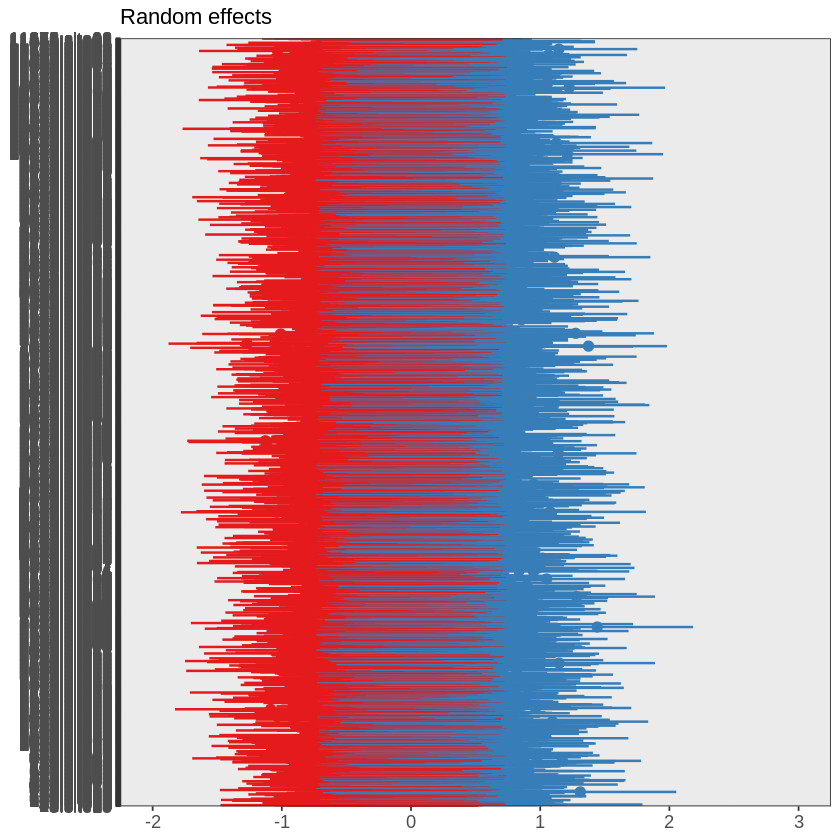

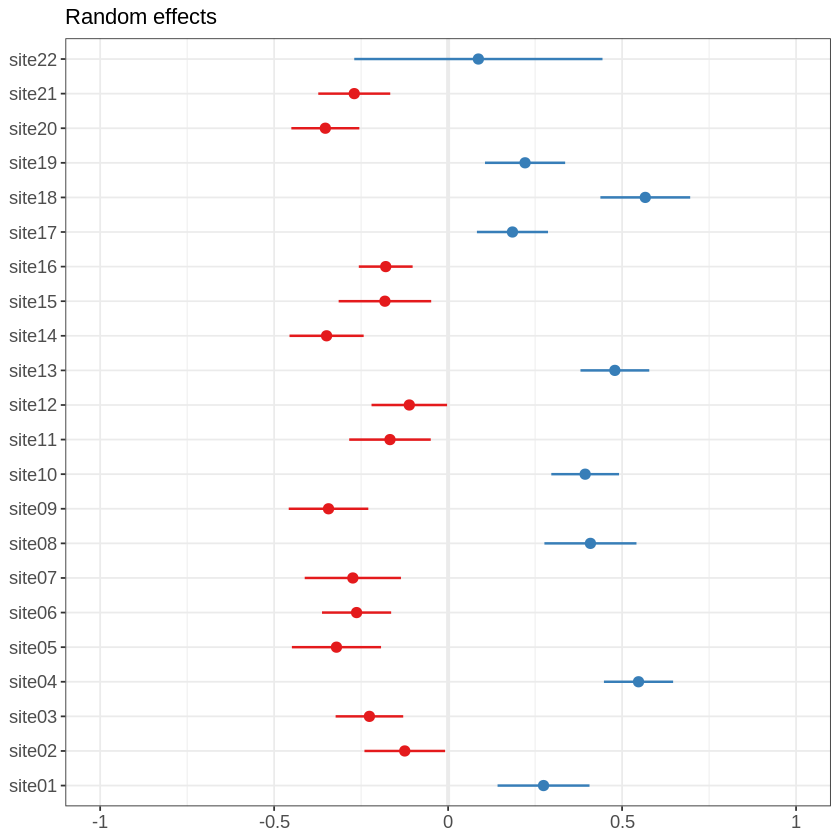

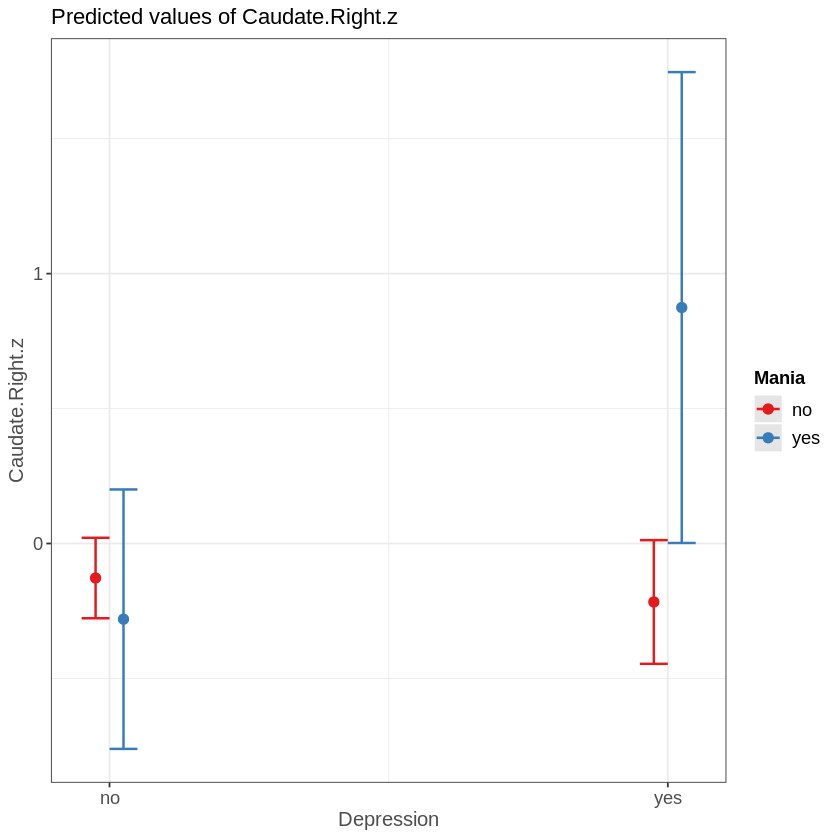

`geom_smooth()` using formula 'y ~ x'



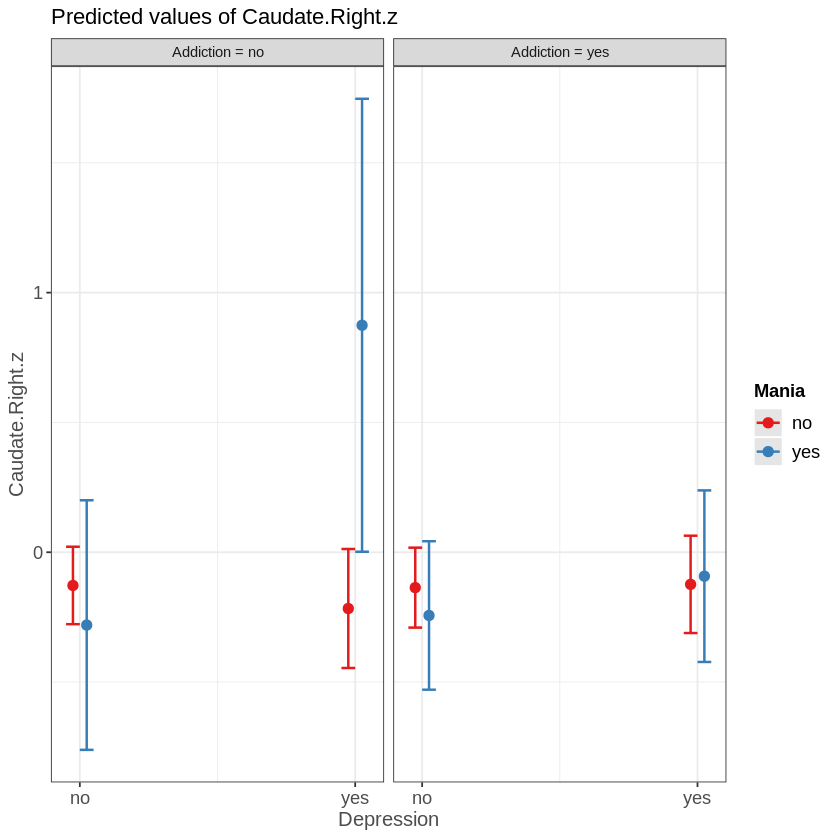

`geom_smooth()` using formula 'y ~ x'



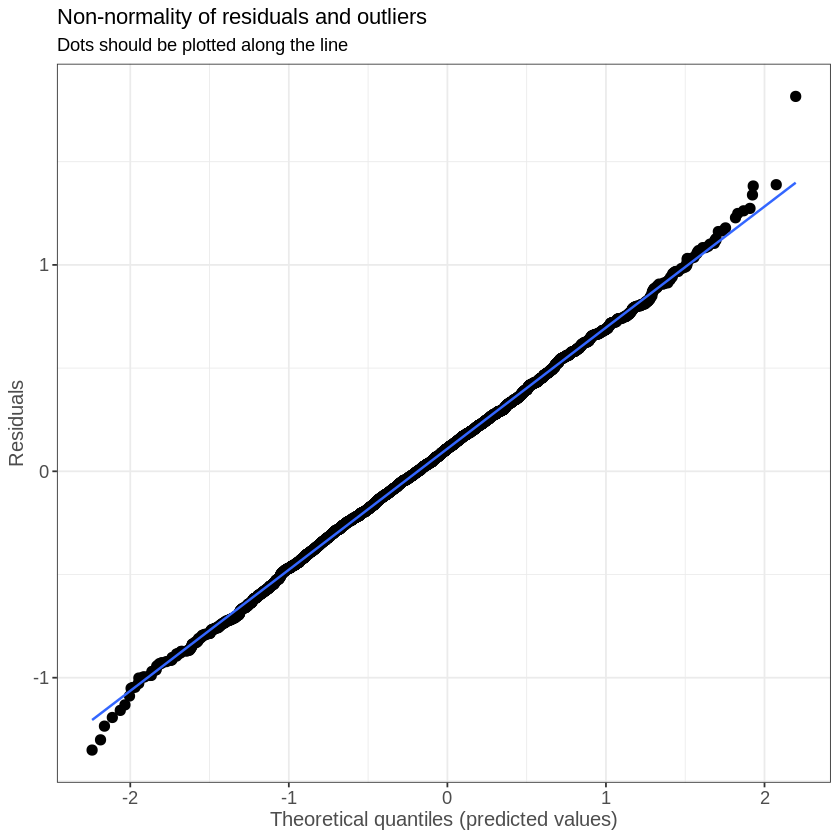

`geom_smooth()` using formula 'y ~ x'



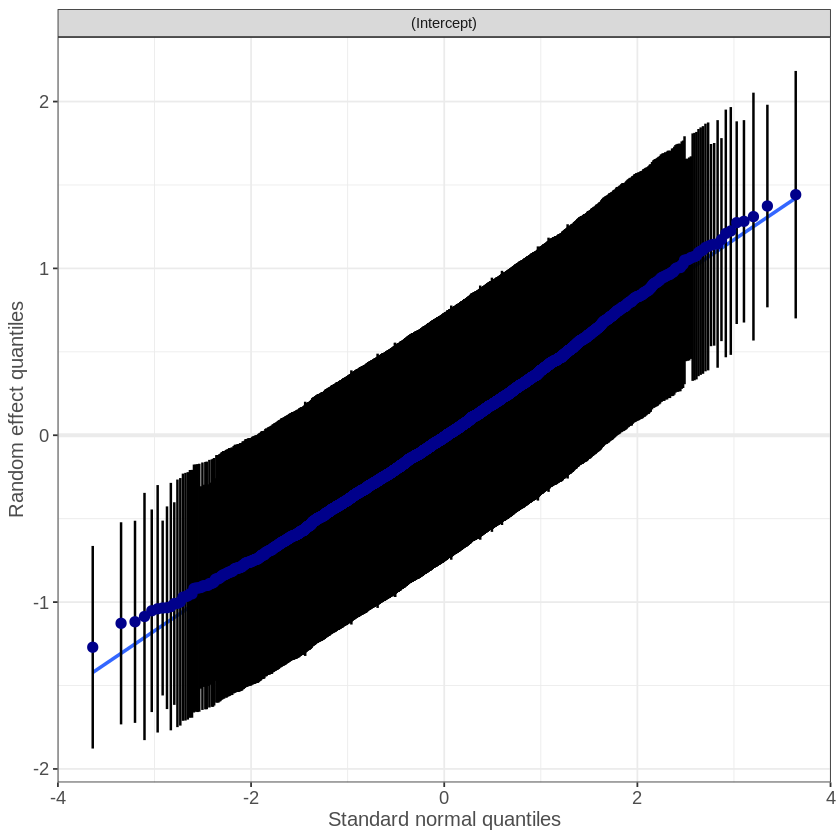

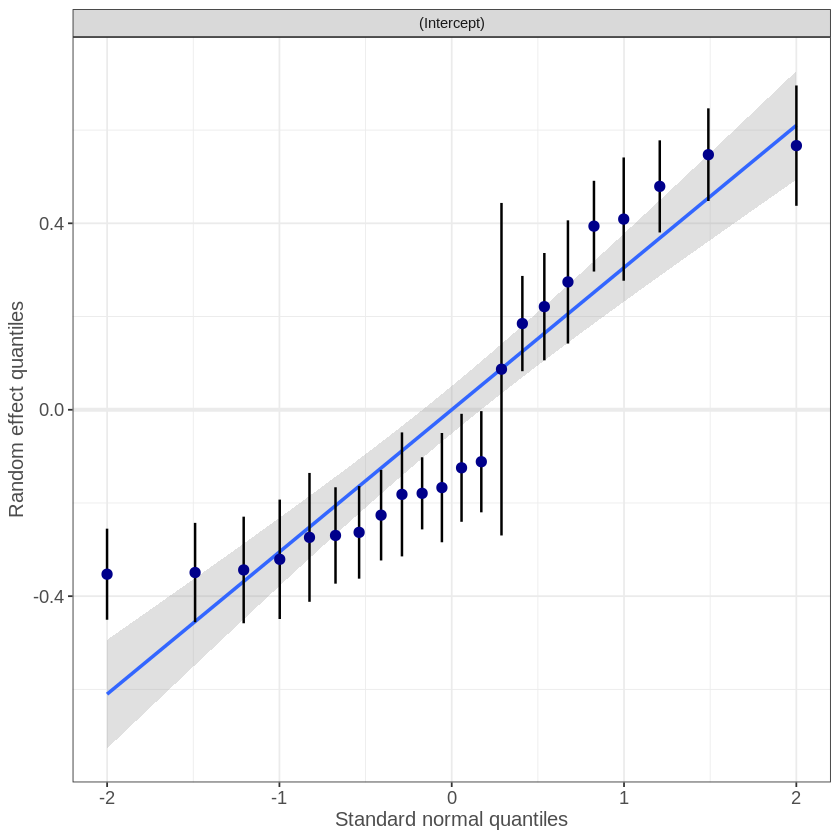

`geom_smooth()` using formula 'y ~ x'



[[1]]

[[2]]
[[2]]$`rel_family_id:site_id_l`

[[2]]$site_id_l


[[3]]

[[4]]


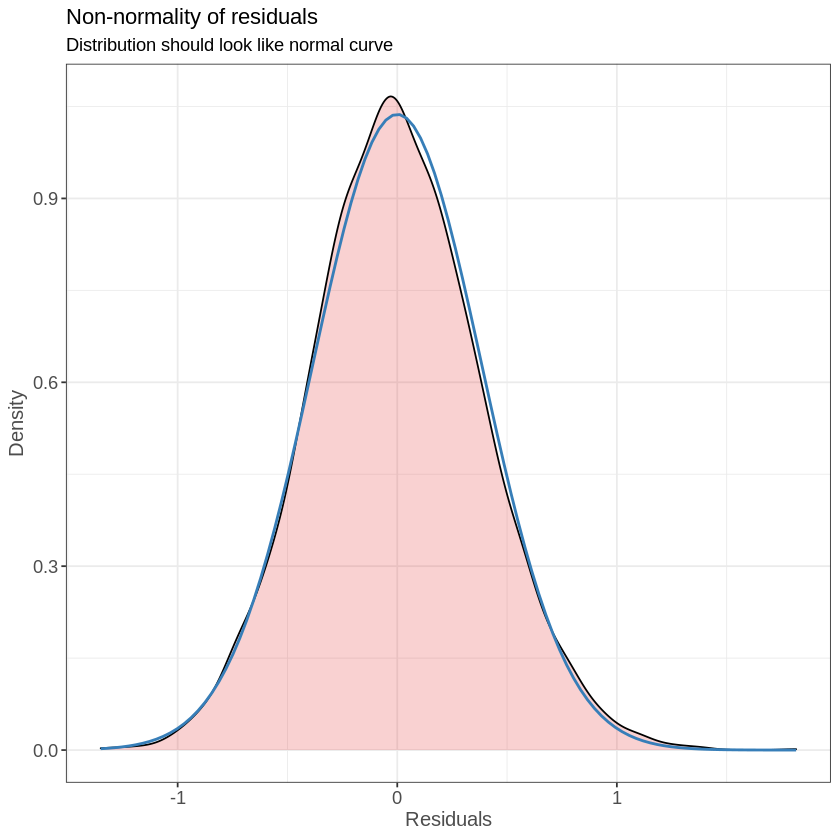

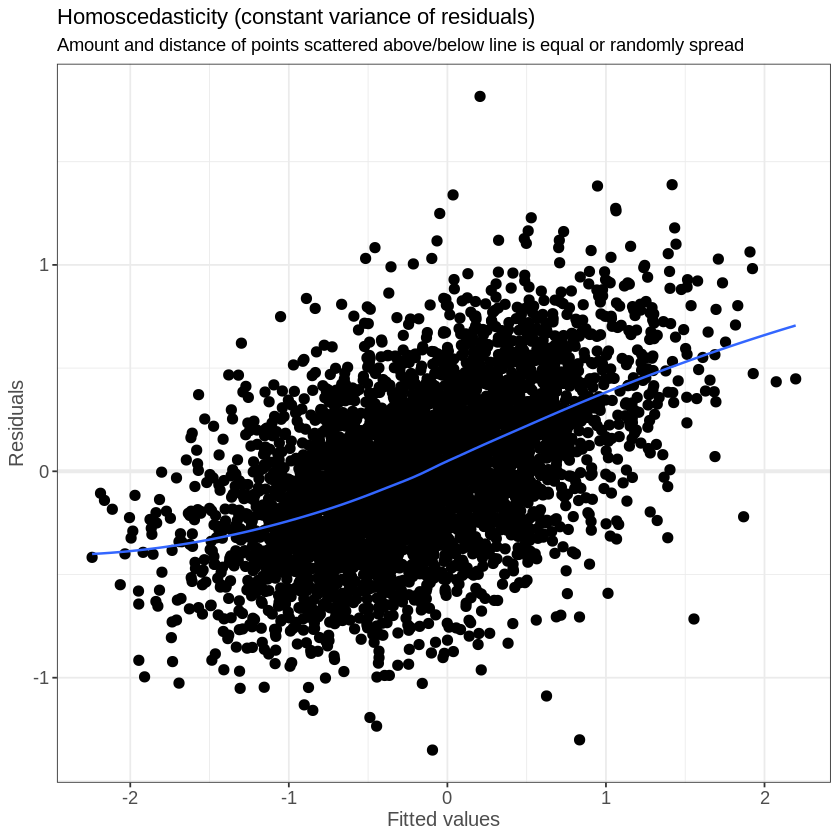

In [47]:
# Interaction plots, random effects + diagnosics
set_theme(
    base = theme_bw(),
)

p1_pred <- plot_model(m1b, type="pred", terms = c("Depression", "Mania")) #plot interaction
p2_pred<- plot_model(m1b, type = "pred", terms = c("Depression", "Mania", "Addiction"))
p1_re <- plot_model(m1b, type = "re", terms = c("Depression", "Mania")) # random effects
p1_diag <- plot_model(m1b, "diag") #assumptions
p1_re
p1_pred
p2_pred
p1_diag

### Interpretation 
##### Two-way interaction
Children with a parental history of depression and mania have higher left caudate volume than children with a parental history of depression alone. 

##### Three-way interaction
Children with parental history of depression and mania have higher left caudate volumes than children with parental history of depression without mania. However, this difference is only observed if no parental history of addiction problems was reported.

#### Problems to work on: 
1. Violation of the assumption of homoscedasticity. Explore gamm4 package (code that was used for DEAP) with acs_propensity_weights
1. Automate the LMM for all dependent variables to minimize manual involvement (human-errors!)
1. Why are there 22 sites in the site variable, while only 21 sites participate in ABCD study.